# Use Case: Federated Learning

**Note:** After we performed these experiments, FuncX changed to Globus Compute.

## Instructions

### Setup

1. Clone and install https://github.com/proxystore/federated-learning
   ```bash
   $ git clone git@github.com:proxystore/federated-learning.git
   $ python -m venv venv
   $ pip install -r requirements.txt
   ```
2. Download the TensorFlow datasets
   ```bash
   $ python download_tf_data.py --name mnist
   ```
3. Configure the test bed
    * For each device in the test bed, install the Python packages as done above.
    * Start a FuncX endpoint and record the UUID.
      ```bash
      $ funcx-endpoint configure fl
      $ funcx-endpoint start fl
      ```
    * Start a ProxyStore endpoint and record the UUID.
      ```bash
      $ proxystore-endpoint configure fl --relay-server <relay-server-address>
      $ proxystore-endpoint start fl
      ```
    * Create a config file with all of the FuncX and ProxyStore endpoint UUIDs.
      See `configs/workstation-endpoints.yml` for an example.
      Note that the "controller" endpoint will not have a FuncX endpoint and the "controller" is the local device (e.g., your laptop) running the `main.py` script.

### Run

1. Run the training locally without ProxyStore.
   ```bash
   $ python main.py --endpoints configs/workstation-endpoints.yml --no-proxystore --data-name mnist
   ```
2. Run with ProxyStore.
   ```bash
   $ python main.py --endpoints configs/workstation-endpoints.yml --data-name mnist
   ```
The workflow will output a file `out/data/results_{timestamp}.csv` which is the file used for the analysis in the rest of this notebook.

In [1]:
%matplotlib inline

from __future__ import annotations

import math
from typing import Any

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.markers as markers
import pandas
import numpy

from matplotlib.ticker import ScalarFormatter

In [2]:
DATA = pandas.read_csv('data/6-federated-learning/federated-learning-results.csv')
DATA = DATA.replace(to_replace={
    "no_store": "Cloud Transfer",
    "proxystore": "EndpointStore"
})
DATA.head()

,round,endpoint_name,transfer_time,data_transfer_size,model_param_size,model_arch_size,local,test_accuracy,test_loss,train_accuracy,train_loss,num_hidden_blocks,store,time_taken_for_process
0,1.0,hawfinch,3.150909,2281716.0,2281615.0,5596.0,False,0.5002,3.525516,0.20,3.525516,1,Cloud Transfer,158.40915
1,1.0,kestrel,4.464043,2281716.0,2281615.0,5596.0,False,0.5002,3.440624,0.24,3.440624,1,Cloud Transfer,158.40915
2,1.0,ryerson,4.977898,2281716.0,2281615.0,5596.0,False,0.5002,3.098623,0.21,3.098623,1,Cloud Transfer,158.40915
3,1.0,jetson,4.599578,2281716.0,2281615.0,5596.0,False,0.5002,3.867584,0.19,3.867584,1,Cloud Transfer,158.40915
4,2.0,hawfinch,3.505748,2281716.0,2281615.0,5596.0,False,0.5511,1.181808,0.59,1.181808,1,Cloud Transfer,158.40915


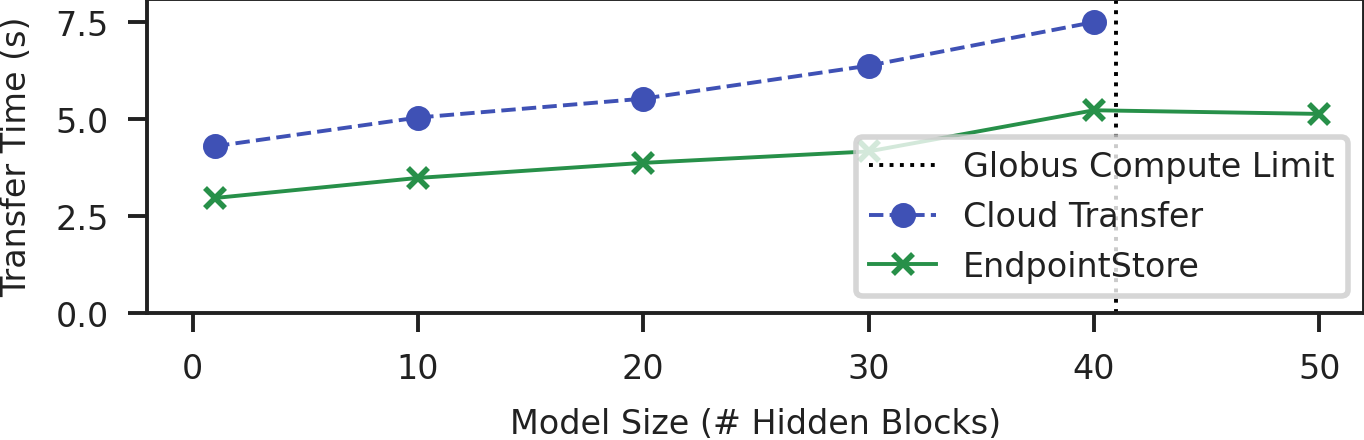

In [11]:
MARKERS = ('o', 'x')
LINES = ('--', '-')

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

baseline = DATA[DATA['store'] == 'Cloud Transfer'].copy()
proxystore = DATA[DATA['store'] == 'EndpointStore'].copy()

baseline['x'] = baseline['num_hidden_blocks']
proxystore['x'] = proxystore['num_hidden_blocks']

baseline = baseline.groupby(['model_param_size']).mean(numeric_only=True)
proxystore = proxystore.groupby(['model_param_size']).mean(numeric_only=True)

ax.axvline(41, label="Globus Compute Limit", color="k", linestyle=":")

for i, (run, data) in enumerate((('Cloud Transfer', baseline), ('EndpointStore', proxystore))):
    ax.plot(
        data['x'],
        data['transfer_time'],
        linestyle=LINES[i],
        marker=MARKERS[i],
        label=run,
    )

ax.set_xlabel('Model Size (# Hidden Blocks)')
ax.set_ylabel('Transfer Time (s)')
ax.set_xlim([-2, 52])
ax.set_ylim([0, 8.1])
ax.legend(loc='lower right', ncols=1)

fig.tight_layout()

fig.set_size_inches(3.35, 0.9)
plt.savefig('figures/federated-learning.pdf', pad_inches=0.05)